<a href="https://colab.research.google.com/github/guilhembr/P7_Scoring/blob/main/POList_01_Cleaning_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Our objective is to explore the dataset from Olist. This EDA will be oriented in order to encourage better pre-processing for Unsupervized Machine Learning modeling. This model aims to find the best number and composition of Customer clusters within the dataset. 

#Import Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


When importing the data we make sure to change the data type for date columns : 

In [ ]:
# root_dir = '/home/pag/Documents/suivi_OC/intros/DS/P5/clustering_olist/'

root_dir = '/content/drive/MyDrive/Colab Notebooks/3_Projets OC/Projet 5/raw data/'

# Orders
orders_raw = pd.read_csv(root_dir + 'olist_orders_dataset.csv',
                         parse_dates=['order_purchase_timestamp',
                                      'order_approved_at',
                                      'order_delivered_carrier_date',
                                      'order_delivered_customer_date',
                                      'order_estimated_delivery_date'])

# Order details
order_items_raw = pd.read_csv(root_dir + 'olist_order_items_dataset.csv',
                              parse_dates=['shipping_limit_date'],
                              dtype={'order_item_id': float})
# Customers
customers_raw = pd.read_csv(root_dir + 'olist_customers_dataset.csv',
                            dtype={'customer_zip_code_prefix': str})

# Product description
products_portuguese_raw = pd.read_csv(root_dir + 'olist_products_dataset.csv')


# Product category
categ_prod_file = root_dir + 'product_category_name_translation.csv'
product_category_translate = pd.read_csv(categ_prod_file)

# Payments
payments_raw = pd.read_csv(root_dir + 'olist_order_payments_dataset.csv')


# Comments
reviews_raw = pd.read_csv(root_dir + 'olist_order_reviews_dataset.csv',
                          parse_dates=['review_creation_date',
                                       'review_answer_timestamp'])

# Sellers
sellers_raw = pd.read_csv(root_dir + 'olist_sellers_dataset.csv')

# Geoloc
geolocation_raw = pd.read_csv(root_dir + 'olist_geolocation_dataset.csv',
                              dtype={'geolocation_zip_code_prefix': str})

#Dataset Overview

In [ ]:
# dataset_list.pop(1)

In [ ]:
#Data shape

dataset = { 
    'Orders' : orders_raw,
    'Order Items' : order_items_raw,

    'Customers' : customers_raw,

    'Products Items' : products_portuguese_raw,
    'Product Catagory Translation' : product_category_translate,
  
    'Payments' : payments_raw, 

    'Review': reviews_raw,

    'Geolocation' : geolocation_raw,

    'Sellers' : sellers_raw
}

for x, y in dataset.items():
  print(f'{x}', (list(y.shape)))

Orders [99441, 8]
Order Items [112650, 7]
Customers [99441, 5]
Products Items [32951, 9]
Product Catagory Translation [71, 2]
Payments [103886, 5]
Review [100000, 7]
Geolocation [1000163, 5]
Sellers [3095, 4]


In [ ]:
#Column names

for x, y in dataset.items():
  print(f'{x}', f'{list(y.columns)}\n')

Orders ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

Order Items ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Customers ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Products Items ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

Product Catagory Translation ['product_category_name', 'product_category_name_english']

Payments ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Review ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']

Geolocation ['g

In [ ]:
#counting missing values
for x, y in dataset.items():
    if y.isnull().any().any():
        print(f'{x}', (list(y.shape)),'\n')
        print(f'{y.isnull().sum()}\n')

Orders [99441, 8] 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Products Items [32951, 9] 

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Review [100000, 7] 

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64



In [ ]:
dataset_list = [orders_raw, 
                order_items_raw, 
                customers_raw, 
                products_portuguese_raw, 
                categ_prod_file, 
                product_category_translate, 
                payments_raw, 
                reviews_raw,
                sellers_raw]

In [ ]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [ ]:
# for dataset in dataset_list:
#   plt.figure(figsize=(20,10), dpi=100)
#   plt.title(f'Taux de remplissage du dataset étudié : {get_df_name(dataset)}]')
#   sns.heatmap(dataset.isna(), cbar=False)

To conclude on this overview : we don't have much missing data (it mainly concerns `review_comment`). 

We will now explore the datasets individually and clean them as we go. 

#Exploration

##Orders

Looking at the dataset columns, we can see orders with different `order_status` : 

In [ ]:
#Check wether order_id have duplicates
orders_raw.duplicated(subset='order_id').any()

False

Each `order_id` is unique in the dataset. 

Text(0.5, 1.0, "Orders' status overview")

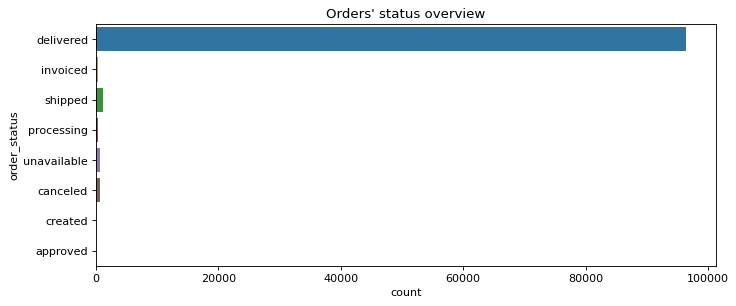

In [ ]:
fig, ax = plt.subplots(figsize=(10,4),dpi=80)

sns.countplot(y = 'order_status', data = orders_raw)

ax.set_title("Orders' status overview")

Most of the orders of the dataset have been delivered by the time this dataset was created. 

We will base our clustering analysis only on delivered orders and therefore will delete undelivered/canceled ones : 

In [ ]:
#Create a un-delivered orders filter
filter = orders_raw['order_status'] != 'delivered'

#Get un-delivered orders count
undel_order_count = orders_raw[filter]['order_id'].shape[0]

#As percentage of total
percentage = round(undel_order_count/orders_raw.shape[0],4)*100

#Print results
print(f'Only {percentage} % of total orders have not been delivered.')

print(f'We will remove the {undel_order_count} corresponding undelivered orders from the dataset.')

Only 2.98 % of total orders have not been delivered.
We will remove the 2963 corresponding undelivered orders from the dataset.


In [ ]:
#Drop corresponding entries
orders_clean = orders_raw.drop(orders_raw[filter].index, axis=0)

#Check
size_old = orders_raw.shape
size_new = orders_clean.shape

print(f'Raw : {size_old}')
print(f'Clean : {size_new}')

Raw : (99441, 8)
Clean : (96478, 8)


In [ ]:
orders_clean.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


Let's now analyze dates : 

In [ ]:
#Extracting infos from purchase date 
orders_clean['order_purchase_year'] = orders_clean['order_purchase_timestamp'].apply(lambda x: x.year)
orders_clean['order_purchase_month'] = orders_clean['order_purchase_timestamp'].apply(lambda x: x.month)

orders_clean['order_purchase_month_name'] = orders_clean['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
orders_clean['order_purchase_year_month'] = orders_clean['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
orders_clean['order_purchase_date'] = orders_clean['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

orders_clean['order_purchase_day'] = orders_clean['order_purchase_timestamp'].apply(lambda x: x.day)
orders_clean['order_purchase_day_of_week'] = orders_clean['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
orders_clean['order_purchase_day_of_week_name'] = orders_clean['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

In [ ]:
orders_clean.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_day_of_week,order_purchase_day_of_week_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,201710,20171002,2,0,Mon
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,201807,20180724,24,1,Tue
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,201808,20180808,8,2,Wed
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,201711,20171118,18,5,Sat
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,201802,20180213,13,1,Tue


It will be interesting to analyse orders regarding the time the order have been made. 
Classes we create are : 
* 0-6am : Night
* 6-12am : Morning
* 12-6pm : Afternoon
* 6-12pm : Evening


In [ ]:
#Creating Categories based on hours of the day
orders_clean['order_purchase_hours'] = orders_clean['order_purchase_timestamp'].apply(lambda x: x.hour)

#Checking the amplitude
#orders_clean['order_purchase_hours'].describe()

#Bins label definition
hours_labels = ['Night', 'Morning', 'Afternoon', 'Evening']

#Cutting bins
orders_clean['order_purchase_hours'] = pd.cut(
                                              orders_clean['order_purchase_hours'], 
                                              bins = 4,
                                              labels=hours_labels)

In [ ]:
orders_clean.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_day_of_week,order_purchase_day_of_week_name,order_purchase_hours
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,201710,20171002,2,0,Mon,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,201807,20180724,24,1,Tue,Evening
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,201808,20180808,8,2,Wed,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,201711,20171118,18,5,Sat,Evening
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,201802,20180213,13,1,Tue,Evening


###Orders per month

In [ ]:
#Prepare data for viz
part_df = orders_clean[['order_id','order_purchase_year','order_purchase_month']]
part_df = part_df.groupby(by=['order_purchase_year','order_purchase_month']).count()
part_df.reset_index(inplace=True)

part_df

,order_purchase_year,order_purchase_month,order_id
0,2016,9,1
1,2016,10,265
2,2016,12,1
3,2017,1,750
4,2017,2,1653
5,2017,3,2546
6,2017,4,2303
7,2017,5,3546
8,2017,6,3135
9,2017,7,3872


https://seaborn.pydata.org/generated/seaborn.lineplot.html

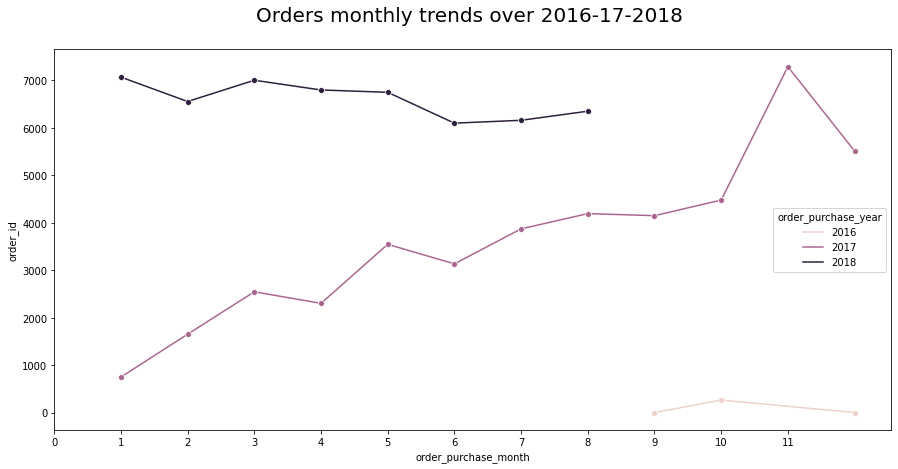

In [ ]:
plt.figure(figsize=(15,7)) # Figure size
sns.lineplot(x='order_purchase_month',
             y='order_id',
             hue='order_purchase_year',
             data=part_df, 
             marker='o') # Specify markers with marker argument
plt.title('Orders monthly trends over 2016-17-2018 \n', fontsize=20) # Title
plt.xticks(ticks=np.arange(0, 12, step=1)) # All values in x-axis
plt.show()

The data gathered is not consistent over the years. Therefore it is not relevant to compare the years in order to try to indentify seasonality. 

So we will visualize the data over the period : 

In [ ]:
#Prepare data for viz
part_df = orders_clean[['order_id','order_purchase_year_month']]
part_df = part_df.groupby(by=['order_purchase_year_month']).count()
part_df.reset_index(inplace=True)

part_df

,order_purchase_year_month,order_id
0,201609,1
1,201610,265
2,201612,1
3,201701,750
4,201702,1653
5,201703,2546
6,201704,2303
7,201705,3546
8,201706,3135
9,201707,3872


In [ ]:
part_df.shape

(23, 2)

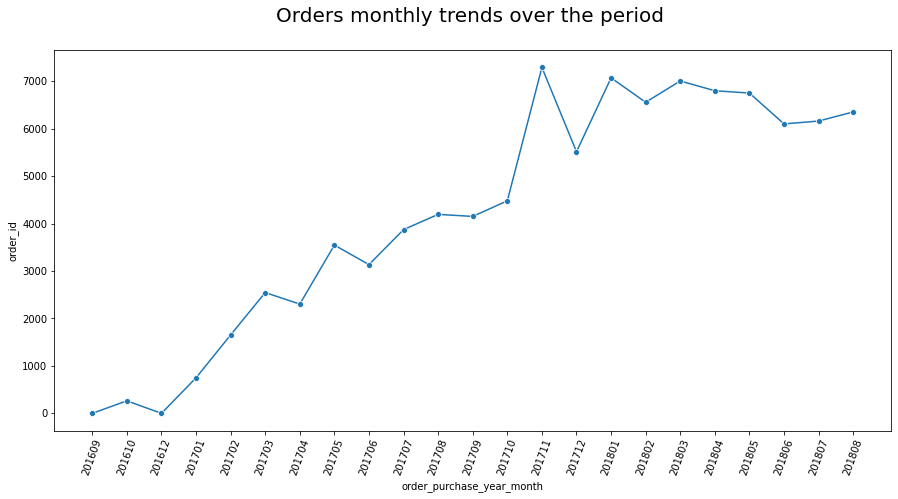

In [ ]:
plt.figure(figsize=(15,7)) # Figure size
sns.lineplot(x='order_purchase_year_month',
             y='order_id',
             data=part_df, 
             marker='o') # Specify markers with marker argument
plt.title('Orders monthly trends over the period \n', fontsize=20) # Title
plt.xticks(ticks=np.arange(0, 23, step=1), rotation=70) # All values in x-axis
plt.show()

We will remove the beginning and the end of the perid : 
* The year `2016` of data as it is not complete



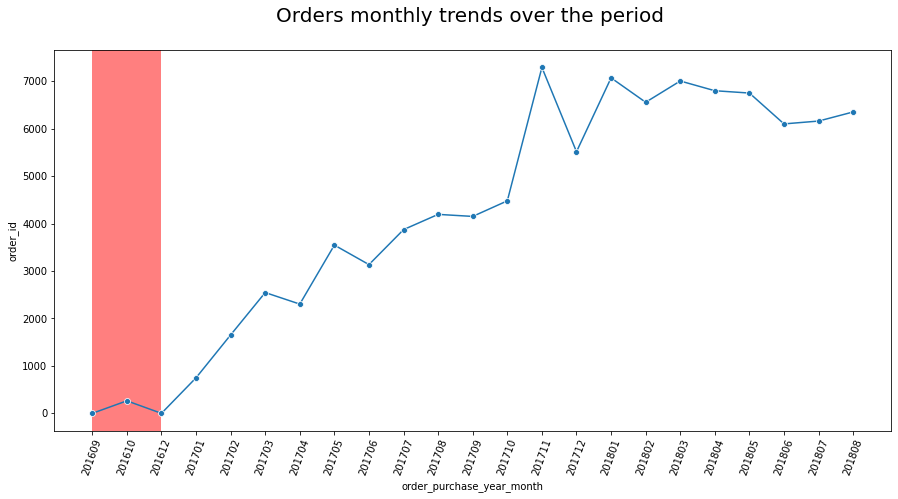

In [ ]:
plt.figure(figsize=(15,7)) # Figure size
sns.lineplot(x='order_purchase_year_month',
             y='order_id',
             data=part_df, 
             marker='o') # Specify markers with marker argument
plt.axvspan(0, 2, facecolor='r', alpha=0.5) #Vertical constant plotting
# plt.axvspan(20, 22, facecolor='r', alpha=0.5)
plt.title('Orders monthly trends over the period \n', fontsize=20) # Title
plt.xticks(ticks=np.arange(0, 23, step=1), rotation=70) # All values in x-axis
plt.show()

Let's compare monthly order trends from the comparable months over 2017 and 2018 : 

In [ ]:
#Prepare data for viz
part_df = orders_clean[['order_id','order_purchase_year','order_purchase_month', 'order_purchase_year_month']]
part_df = part_df.groupby(by=['order_purchase_year','order_purchase_month','order_purchase_year_month']).count()
part_df.reset_index(inplace=True)

filter1 = part_df['order_purchase_year_month'].astype(int).between(201701, 201808, inclusive='both')
# part_df['order_purchase_year_month'].astype(int)

#list of month to remove
# list_of_month = ['201709','201710', '201711', '201712', '201801', '201802']

# filter2 = ~part_df['order_purchase_year_month'].isin(list_of_month) #Tilde : ALT+N

#Apply filters
part_df = part_df[filter1]
# part_df = part_df[filter2]

part_df

,order_purchase_year,order_purchase_month,order_purchase_year_month,order_id
3,2017,1,201701,750
4,2017,2,201702,1653
5,2017,3,201703,2546
6,2017,4,201704,2303
7,2017,5,201705,3546
8,2017,6,201706,3135
9,2017,7,201707,3872
10,2017,8,201708,4193
11,2017,9,201709,4150
12,2017,10,201710,4478


In [ ]:
orders_clean['order_purchase_year_month'].value_counts().sort_index(ascending=True)

201609       1
201610     265
201612       1
201701     750
201702    1653
201703    2546
201704    2303
201705    3546
201706    3135
201707    3872
201708    4193
201709    4150
201710    4478
201711    7289
201712    5513
201801    7069
201802    6555
201803    7003
201804    6798
201805    6749
201806    6099
201807    6159
201808    6351
Name: order_purchase_year_month, dtype: int64

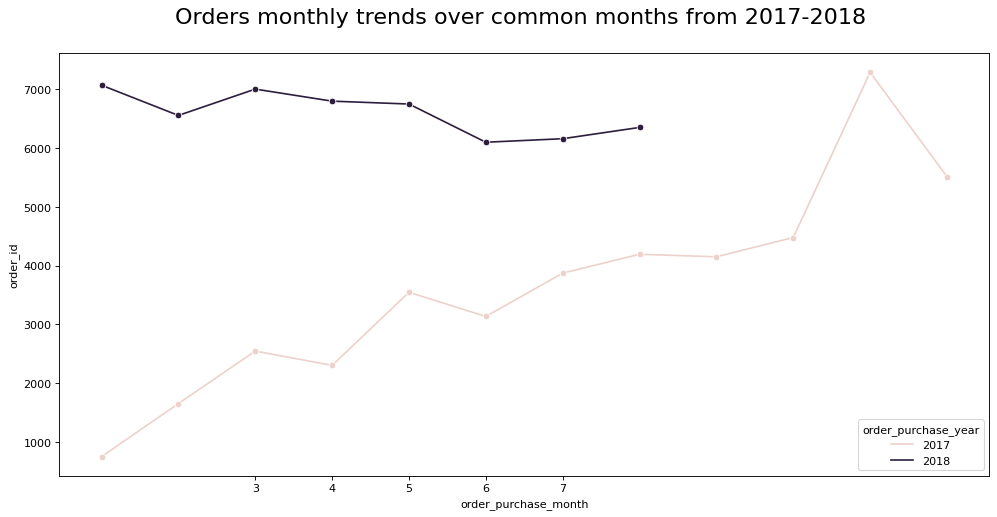

In [ ]:
plt.figure(figsize=(15,7), dpi=80) # Figure size
sns.lineplot(x='order_purchase_month',
             y='order_id',
             hue='order_purchase_year',
             data=part_df, 
             marker='o') # Specify markers with marker argument
plt.title('Orders monthly trends over common months from 2017-2018 \n', fontsize=20) # Title
plt.xticks(ticks=np.arange(3, 8, step=1)) # All values in x-axis
plt.show()

We notice an overall growth over the year for the comparable months. 

In [ ]:
#Removing the extreme periods
month_to_remove = ['201609', '201610', '201612'] #, '201701', '201806', '201807', '201808']
filter = ~orders_clean['order_purchase_year_month'].isin(month_to_remove)

orders_clean = orders_clean[filter]
orders_clean

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_day_of_week,order_purchase_day_of_week_name,order_purchase_hours
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,201710,20171002,2,0,Mon,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,201807,20180724,24,1,Tue,Evening
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,201808,20180808,8,2,Wed,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,201711,20171118,18,5,Sat,Evening
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,201802,20180213,13,1,Tue,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,2017,3,Mar,201703,20170309,9,3,Thu,Morning
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,2018,2,Feb,201802,20180206,6,1,Tue,Afternoon
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,2017,8,Aug,201708,20170827,27,6,Sun,Afternoon
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2018,1,Jan,201801,20180108,8,0,Mon,Evening


###Orders per dayweek

In [ ]:
orders_clean.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_day_of_week,order_purchase_day_of_week_name,order_purchase_hours
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,201710,20171002,2,0,Mon,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,201807,20180724,24,1,Tue,Evening
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,201808,20180808,8,2,Wed,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,201711,20171118,18,5,Sat,Evening
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,201802,20180213,13,1,Tue,Evening


In [ ]:
orders_clean['order_purchase_day_of_week_name'].value_counts() / orders_clean['order_purchase_day_of_week_name'].shape[0]*100

Mon    16.276725
Tue    16.057415
Wed    15.633348
Thu    14.843417
Fri    14.183409
Sun    12.072424
Sat    10.933261
Name: order_purchase_day_of_week_name, dtype: float64

In [ ]:
orders_clean['order_purchase_day_of_week_name'].value_counts().index

Index(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sun', 'Sat'], dtype='object')

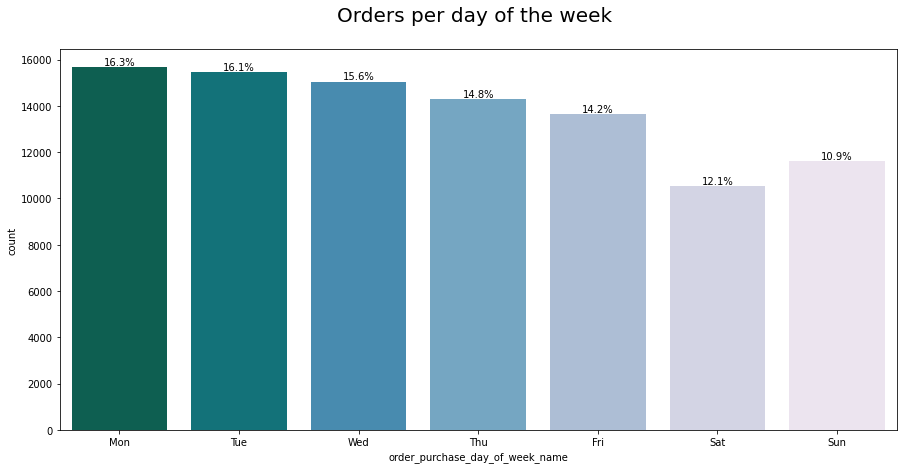

In [ ]:
#Percentage labels
count_order_per_day_of_week = orders_clean['order_purchase_day_of_week_name'].value_counts()
total_orders = orders_clean['order_purchase_day_of_week_name'].shape[0]
percentage = count_order_per_day_of_week / total_orders *100

#Countplot
plt.figure(figsize=(15,7))

#Reindex to keep the correct order
day_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
percentage.reindex(day_of_week)

ax = sns.countplot(x='order_purchase_day_of_week_name', 
                   order=day_of_week,
                   data=orders_clean, 
                   palette='PuBuGn_r')

#Use patches location and annotate function to add label on topof the bar
patches = ax.patches
for i in range(len(patches)):
  x = patches[i].get_x() + patches[i].get_width() / 2
  y = patches[i].get_height() + 100
  ax.annotate('{:.1f}%'.format(percentage[i]), (x,y), ha='center')

plt.title('Orders per day of the week \n', fontsize=20) # Title
plt.show()

In [ ]:
orders_clean['order_purchase_day_of_week_name'].describe()

count     96211
unique        7
top         Mon
freq      15660
Name: order_purchase_day_of_week_name, dtype: object

In [ ]:
top_day = orders_clean['order_purchase_day_of_week_name'].describe()['top']
top_freq = orders_clean['order_purchase_day_of_week_name'].describe()['freq']
average_order_per_dayofweek = round(orders_clean['order_purchase_day_of_week_name'].value_counts().mean(),2)

In [ ]:
print(f'An average of {average_order_per_dayofweek} orders have been placed each day. {top_day} is the best day with a frequence of {top_freq}.')

An average of 13744.43 orders have been placed each day. Mon is the best day with a frequence of 15660.


In [ ]:
orders_clean.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_day_of_week,order_purchase_day_of_week_name,order_purchase_hours
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,201710,20171002,2,0,Mon,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,201807,20180724,24,1,Tue,Evening
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,201808,20180808,8,2,Wed,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,201711,20171118,18,5,Sat,Evening
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,201802,20180213,13,1,Tue,Evening


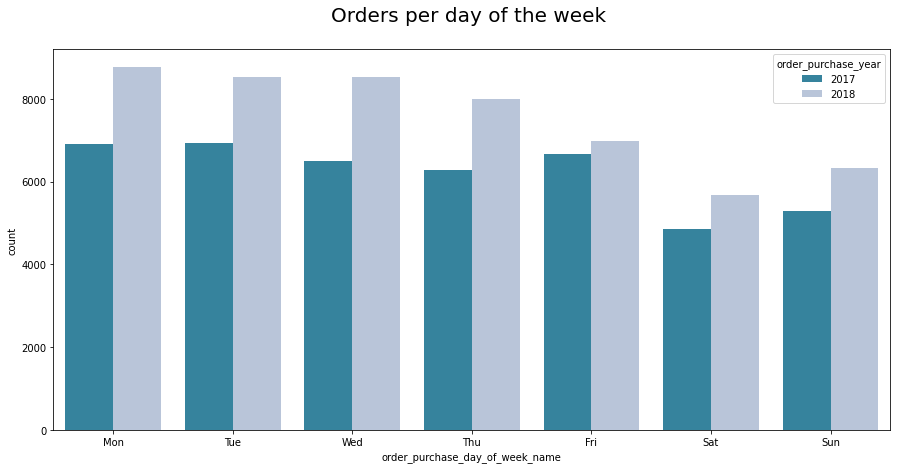

In [ ]:
#Countplot
plt.figure(figsize=(15,7))

ax = sns.countplot(x='order_purchase_day_of_week_name', 
                   data=orders_clean, 
                   order=day_of_week,
                   hue='order_purchase_year', 
                   palette='PuBuGn_r')

plt.title('Orders per day of the week \n', fontsize=20) # Title
plt.show()

Surprisingly, most of the purchases have been done during the calendar week rather than during week-ends.  

###Orders per time of day

In [ ]:
orders_clean['order_purchase_hours'].value_counts().index

CategoricalIndex(['Afternoon', 'Evening', 'Morning', 'Night'], categories=['Night', 'Morning', 'Afternoon', 'Evening'], ordered=True, dtype='category')

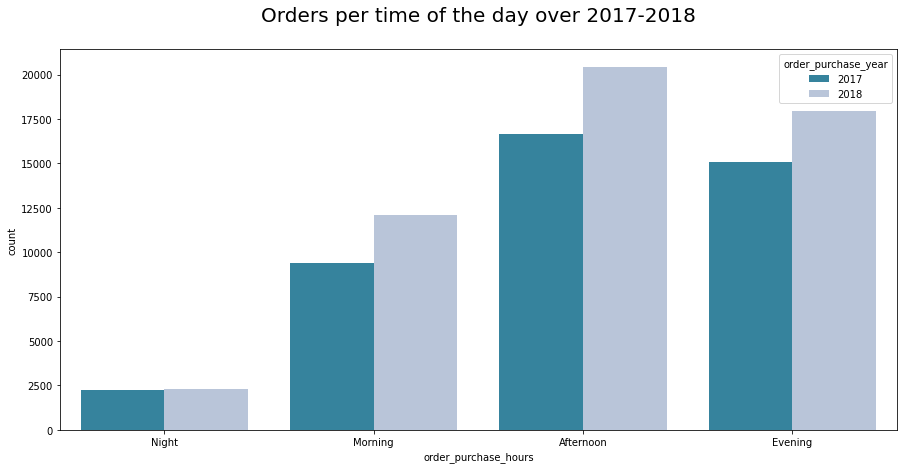

In [ ]:
#Countplot
plt.figure(figsize=(15,7))

time_of_day = ['Night', 'Morning', 'Afternoon', 'Evening']

ax = sns.countplot(x='order_purchase_hours', 
                   data=orders_clean, 
                   order=time_of_day,
                   hue='order_purchase_year', 
                   palette='PuBuGn_r')

plt.title('Orders per time of the day over 2017-2018\n', fontsize=20) # Title
plt.show()

Most of the purchases have been done during afternoon or evening. 

###Daylag

From an e-commerce client point of view, the swiftness of order placing and delivery can be a key for satisfaction. 

We will therefore analyse the following daylag : 
* Placing Daylag : Purchase vs approval
* Shipping Daylag : Approval vs Carrier delivery
* Estimation Daylag : Effective delivery vs Estimated delivery
* Carrier Daylag : Carrier delivery date vs Customer delivery date

In [ ]:
orders_clean.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_day_of_week,order_purchase_day_of_week_name,order_purchase_hours
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,201710,20171002,2,0,Mon,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,201807,20180724,24,1,Tue,Evening
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,201808,20180808,8,2,Wed,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,201711,20171118,18,5,Sat,Evening
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,201802,20180213,13,1,Tue,Evening


In [ ]:
orders_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [ ]:
#Removing Missing values
orders_clean.dropna(subset=['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
                    , inplace=True)

#Checking result
orders_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96188 entries, 0 to 99440
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   order_id                         96188 non-null  object        
 1   customer_id                      96188 non-null  object        
 2   order_status                     96188 non-null  object        
 3   order_purchase_timestamp         96188 non-null  datetime64[ns]
 4   order_approved_at                96188 non-null  datetime64[ns]
 5   order_delivered_carrier_date     96188 non-null  datetime64[ns]
 6   order_delivered_customer_date    96188 non-null  datetime64[ns]
 7   order_estimated_delivery_date    96188 non-null  datetime64[ns]
 8   order_purchase_year              96188 non-null  int64         
 9   order_purchase_month             96188 non-null  int64         
 10  order_purchase_month_name        96188 non-null  object   

In [ ]:
orders_clean.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_day_of_week,order_purchase_day_of_week_name,order_purchase_hours
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,201710,20171002,2,0,Mon,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,201807,20180724,24,1,Tue,Evening
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,201808,20180808,8,2,Wed,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,201711,20171118,18,5,Sat,Evening
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,201802,20180213,13,1,Tue,Evening


In [ ]:
#Extracting Order date infos
orders_clean['order_approved_date'] = orders_clean['order_approved_at'].apply(lambda x: x.strftime('%Y%m%d'))
orders_clean['order_delivery_carrier_date'] = orders_clean['order_delivered_carrier_date'].apply(lambda x: x.strftime('%Y%m%d'))
orders_clean['order_delivery_customer_estimated'] = orders_clean['order_estimated_delivery_date'].apply(lambda x: x.strftime('%Y%m%d'))
orders_clean['order_delivery_customer_date'] = orders_clean['order_delivered_customer_date'].apply(lambda x: x.strftime('%Y%m%d'))

#Footing Daylags
orders_clean['placing_daylag'] = orders_clean['order_approved_date'].astype(int) - orders_clean['order_purchase_date'].astype(int) 
orders_clean['shipping_daylag'] = orders_clean['order_delivery_carrier_date'].astype(int) - orders_clean['order_approved_date'].astype(int) 
orders_clean['estimation_daylag'] = orders_clean['order_delivery_customer_date'].astype(int) - orders_clean['order_delivery_customer_estimated'].astype(int) 
orders_clean['carrier_daylag'] = orders_clean['order_delivery_customer_date'].astype(int) - orders_clean['order_delivery_carrier_date'].astype(int) 


In [ ]:
#Prepare data for viz
part_df = orders_clean[['placing_daylag', 'shipping_daylag', 'estimation_daylag', 'carrier_daylag', 'order_purchase_year_month']]
part_df = part_df.groupby(by=['order_purchase_year_month']).mean()
part_df.reset_index(inplace=True)

part_df

,order_purchase_year_month,placing_daylag,shipping_daylag,estimation_daylag,carrier_daylag
0,201701,3.656417,13.949198,-95.466578,40.898396
1,201702,2.078611,14.951249,-61.013406,29.867154
2,201703,1.063236,7.172820,-41.766693,32.124116
3,201704,2.224056,13.339991,-38.391229,41.145897
4,201705,1.500987,7.037518,-45.209873,25.626798
5,201706,1.445933,6.321212,-43.571611,28.596491
6,201707,2.052686,8.454029,-41.553202,27.588326
7,201708,1.524446,6.807298,-42.536370,25.135225
8,201709,1.271873,8.195710,-33.173536,31.235960
9,201710,1.721751,7.933899,-40.963600,32.295668


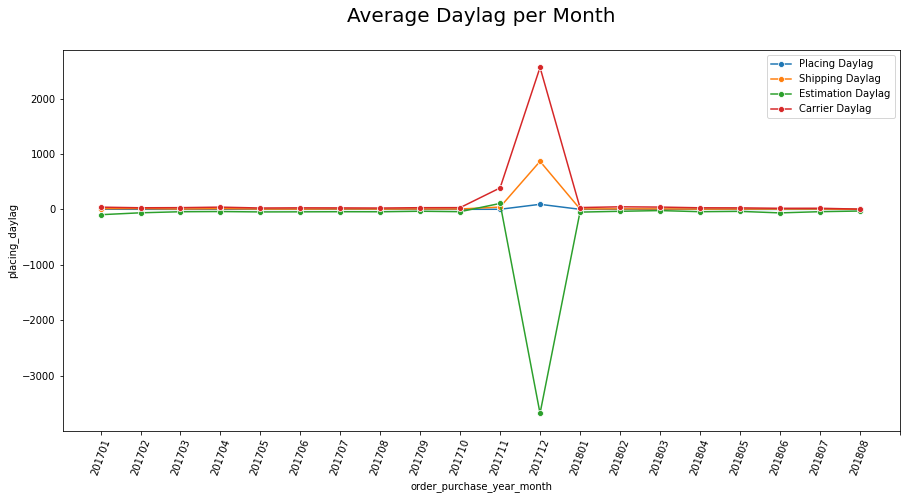

In [ ]:
plt.figure(figsize=(15,7)) # Figure size

sns.lineplot(x='order_purchase_year_month',
             y='placing_daylag',
             data=part_df, 
             label='Placing Daylag',
             marker='o') # Specify markers with marker argument

sns.lineplot(x='order_purchase_year_month',
             y='shipping_daylag',
             data=part_df, 
             label='Shipping Daylag',
             marker='o')

sns.lineplot(x='order_purchase_year_month',
             y='estimation_daylag',
             data=part_df, 
             label='Estimation Daylag',
             marker='o')

sns.lineplot(x='order_purchase_year_month',
             y='carrier_daylag',
             data=part_df, 
             label='Carrier Daylag',
             marker='o')


plt.title('Average Daylag per Month\n', fontsize=20) # Title
plt.xticks(ticks=np.arange(0, 21, step=1), rotation=70) # All values in x-axis
plt.show()

As we could have expected : the placing daylag is relatively steady and close to zero over the time. 




We would therefore gather the other daylags in a single indicator : 
* **Actual Lead Time (days)** : Number of days taken to deliver a product to the customer, from the moment an order has been placed in the system. 

In [ ]:
# #Actual Lead Time
# orders_clean['delai_de_livraison'] = orders_clean['order_delivery_customer_date'].astype(int) - orders_clean['order_approved_at'].astype(int) 

orders_clean['delivery_timing'] = (
    orders_clean['order_delivered_customer_date'] -
    orders_clean['order_purchase_timestamp']
).apply(lambda x: x.days)

In [ ]:
# orders_clean.drop(columns={'actual_lead_time', 'delai_de_livraison'}, inplace=True)

In [ ]:
orders_clean[['order_delivered_customer_date', 'order_purchase_timestamp', 'delivery_timing']]

,order_delivered_customer_date,order_purchase_timestamp,delivery_timing
0,2017-10-10 21:25:13,2017-10-02 10:56:33,8
1,2018-08-07 15:27:45,2018-07-24 20:41:37,13
2,2018-08-17 18:06:29,2018-08-08 08:38:49,9
3,2017-12-02 00:28:42,2017-11-18 19:28:06,13
4,2018-02-16 18:17:02,2018-02-13 21:18:39,2
...,...,...,...
99436,2017-03-17 15:08:01,2017-03-09 09:54:05,8
99437,2018-02-28 17:37:56,2018-02-06 12:58:58,22
99438,2017-09-21 11:24:17,2017-08-27 14:46:43,24
99439,2018-01-25 23:32:54,2018-01-08 21:28:27,17


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


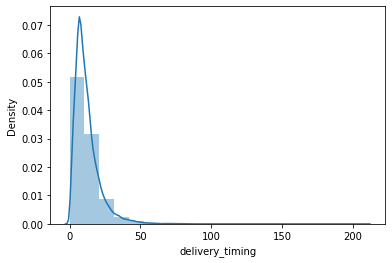

In [ ]:
sns.distplot(orders_clean['delivery_timing'],bins=20)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


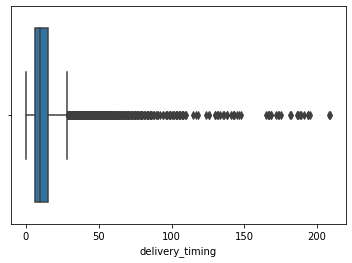

In [ ]:
#check outliers
sns.boxplot(orders_clean['delivery_timing'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


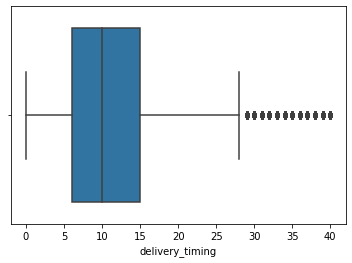

In [ ]:
#remove outliers
z = np.abs(stats.zscore(orders_clean['delivery_timing']))
orders_clean_filtered = orders_clean[(z < 3)]
orders_clean_outliers = orders_clean[(z > 3)]
sns.boxplot(orders_clean_filtered['delivery_timing'])

In [ ]:
orders_clean_filtered['delivery_timing'].describe()

count    94595.000000
mean        11.359903
std          7.315954
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max         40.000000
Name: delivery_timing, dtype: float64

In [ ]:
orders_clean_outliers.shape[0] / orders_clean.shape[0] * 100

1.6561317420052397

It seems decent to remove 2.5% of entries as outliers. We will proceed this way. 

In [ ]:
orders_clean = orders_clean_filtered

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


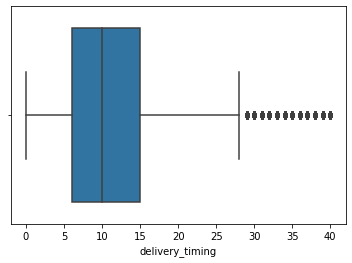

In [ ]:
#check for outliers again
sns.boxplot(orders_clean['delivery_timing'])

Since there still seems to have some heavy outliers that could add noise to our data, we will remove them using the same rule as before (items > Z score > 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


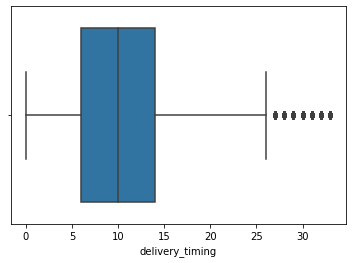

In [ ]:
#remove outliers
z = np.abs(stats.zscore(orders_clean['delivery_timing']))
orders_clean_filtered = orders_clean[(z < 3)]
orders_clean_outliers = orders_clean[(z > 3)]
sns.boxplot(orders_clean_filtered['delivery_timing'])

In [ ]:
orders_clean_outliers.shape[0] / orders_clean.shape[0] * 100

1.5539933400285426

Number of outliers removed also seems consistent. We proceed this way. 

In [ ]:
orders_clean = orders_clean_filtered

In [ ]:
orders_clean['delivery_timing'].describe()

count    93125.000000
mean        10.963264
std          6.647042
min          0.000000
25%          6.000000
50%         10.000000
75%         14.000000
max         33.000000
Name: delivery_timing, dtype: float64

##Customers

In [ ]:
#customer by region / state / city

customers_raw

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,03937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,06764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


##Products

In [ ]:
products_portuguese_raw

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


##Payments

In [ ]:
#Delete baskets equals to zero
#OK none

##Reviews

In [ ]:
reviews_raw.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


#Export

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/3_Projets OC/Projet 5/raw data/"

#Paths 
orders_exp = path + "olist_orders_dataset_cleaned.csv"

#Export
orders_clean.to_csv(orders_exp, index=False)


In [ ]:
orders_clean.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_day_of_week,order_purchase_day_of_week_name,order_purchase_hours,order_approved_date,order_delivery_carrier_date,order_delivery_customer_estimated,order_delivery_customer_date,placing_daylag,shipping_daylag,estimation_daylag,carrier_daylag,delivery_timing
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,201710,20171002,2,0,Mon,Morning,20171002,20171004,20171018,20171010,0,2,-8,6,8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,201807,20180724,24,1,Tue,Evening,20180726,20180726,20180813,20180807,2,0,-6,81,13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,201808,20180808,8,2,Wed,Morning,20180808,20180808,20180904,20180817,0,0,-87,9,9
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,201711,20171118,18,5,Sat,Evening,20171118,20171122,20171215,20171202,0,4,-13,80,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,201802,20180213,13,1,Tue,Evening,20180213,20180214,20180226,20180216,0,1,-10,2,2


In [ ]:
order_items_raw.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1.0,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1.0,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1.0,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1.0,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
